In [20]:
import numpy  as np
import pandas as pd

In [21]:
df = pd.read_csv('data/development.csv').set_index('Id')
df.head()

df.drop(['sampling_rate', 'path', 'num_characters'], axis=1, inplace=True)
df['tempo'] = df['tempo'].apply(lambda x: x.replace('[', '').replace(']', '')).astype('float')
df.drop('ethnicity', axis=1, inplace=True)
gender =  {'male': 1, 'female': 0, "famale": 0}
df['gender'] = df['gender'].map(gender)


from sklearn.model_selection import train_test_split
X = df.drop('age', axis=1)
y = df['age']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

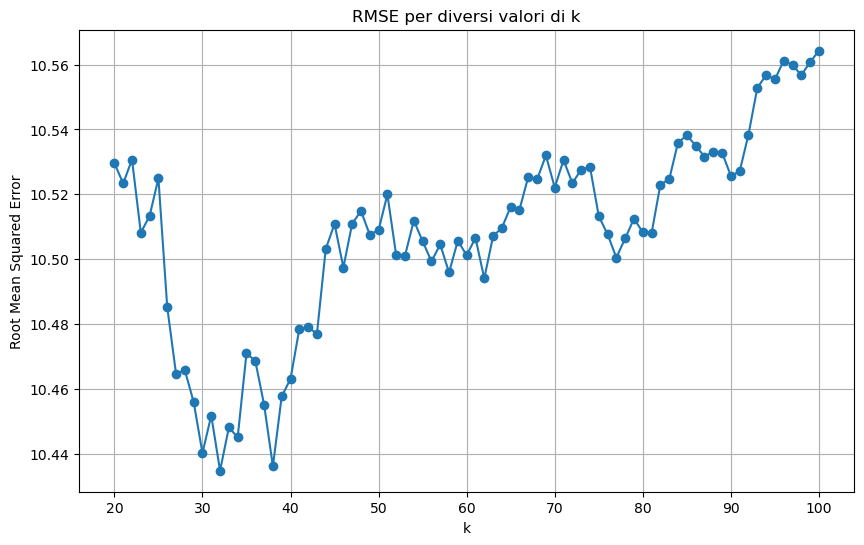

In [22]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

# Creare e addestrare il modello per diversi valori di k
scaler = StandardScaler()
X_s = scaler.fit_transform(X_train)
X_t_s = scaler.transform(X_test)

import matplotlib.pyplot as plt

k_values = range(20, 101)
rmse_values = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_s, y_train)
    
    # Effettuare previsioni sui dati di test
    y_pred = knn.predict(X_t_s)
    
    # Valutare le prestazioni del modello
    rmse = root_mean_squared_error(y_test, y_pred)  
    rmse_values.append(rmse)

# Creare il grafico
plt.figure(figsize=(10, 6))
plt.plot(k_values, rmse_values, marker='o')
plt.xlabel('k')
plt.ylabel('Root Mean Squared Error')
plt.title('RMSE per diversi valori di k')
plt.grid(True)
plt.show()

In [23]:
min_rmse = min(rmse_values)
best_k = k_values[rmse_values.index(min_rmse)]
print(f"Il valore minimo di RMSE è: {min_rmse} e il suo corrispettivo k è: {best_k}")

Il valore minimo di RMSE è: 10.434793179497746 e il suo corrispettivo k è: 32


In [24]:
from itertools import combinations

# Trova tutti i possibili sottoinsiemi delle colonne
columns = X.columns
subsets = []

for r in range(1, len(columns) + 1):
    subsets.extend(combinations(columns, r))

In [25]:
from itertools import combinations
from tqdm import tqdm

# Funzione per calcolare l'RMSE
def calculate_rmse(X_train, X_test, y_train, y_test, features):
    X_train_temp = X_train[list(features)]
    X_test_temp = X_test[list(features)]
    
    # Standardizzare i dati
    X_s_temp = scaler.fit_transform(X_train_temp)
    X_t_s_temp = scaler.transform(X_test_temp)
    
    # Addestrare il modello
    knn_temp = KNeighborsRegressor(n_neighbors=best_k)
    knn_temp.fit(X_s_temp, y_train)
    
    # Effettuare previsioni sui dati di test
    y_pred_temp = knn_temp.predict(X_t_s_temp)
    
    # Calcolare l'RMSE
    rmse_temp = root_mean_squared_error(y_test, y_pred_temp)
    return rmse_temp

# Trova tutti i possibili sottoinsiemi delle colonne
columns = X_train.columns
subsets = []

for r in range(1, len(columns) + 1):
    subsets.extend(combinations(columns, r))

rmses = []  

for subset in tqdm(subsets):
    rmse_temp = calculate_rmse(X_train, X_test, y_train, y_test, subset)
    rmses.append(rmse_temp)
    
# Trova il subset più corto con un RMSE entro 0.01 rispetto al minimo
best_rmse = min(rmses)
tolerance = 0.01
best_subset = None

for subset, rmse in zip(subsets, rmses):
    if rmse <= best_rmse + tolerance:
        if best_subset is None or len(subset) < len(best_subset):
            best_subset = subset

print(f"Il subset di feature per cui l'RMSE è il più basso è: {best_subset} con un RMSE di: {best_rmse}")

100%|██████████| 16383/16383 [05:36<00:00, 48.63it/s]

Il subset di feature per cui l'RMSE è il più basso è: ('gender', 'mean_pitch', 'min_pitch', 'jitter', 'shimmer', 'tempo', 'hnr', 'num_pauses', 'silence_duration') con un RMSE di: 10.259397302512808


In [37]:
idx = np.argsort(rmses)[:10]

for i in idx:    
    print(f"Len: {len(subsets[i])} - Subset: {subsets[i]} - RMSE: {rmses[i]}")   

Len: 9 - Subset: ('gender', 'mean_pitch', 'jitter', 'shimmer', 'tempo', 'hnr', 'num_words', 'num_pauses', 'silence_duration') - RMSE: 10.259397302512808
Len: 10 - Subset: ('gender', 'mean_pitch', 'min_pitch', 'jitter', 'shimmer', 'tempo', 'hnr', 'num_words', 'num_pauses', 'silence_duration') - RMSE: 10.259774152271149
Len: 9 - Subset: ('gender', 'mean_pitch', 'min_pitch', 'jitter', 'shimmer', 'tempo', 'hnr', 'num_pauses', 'silence_duration') - RMSE: 10.260993792266406
Len: 10 - Subset: ('gender', 'mean_pitch', 'max_pitch', 'jitter', 'shimmer', 'tempo', 'hnr', 'num_words', 'num_pauses', 'silence_duration') - RMSE: 10.264170628925223
Len: 11 - Subset: ('gender', 'mean_pitch', 'max_pitch', 'min_pitch', 'jitter', 'shimmer', 'tempo', 'hnr', 'num_words', 'num_pauses', 'silence_duration') - RMSE: 10.267309539021971
Len: 8 - Subset: ('gender', 'mean_pitch', 'jitter', 'shimmer', 'tempo', 'hnr', 'num_pauses', 'silence_duration') - RMSE: 10.269706628464176
Len: 10 - Subset: ('gender', 'mean_pitch

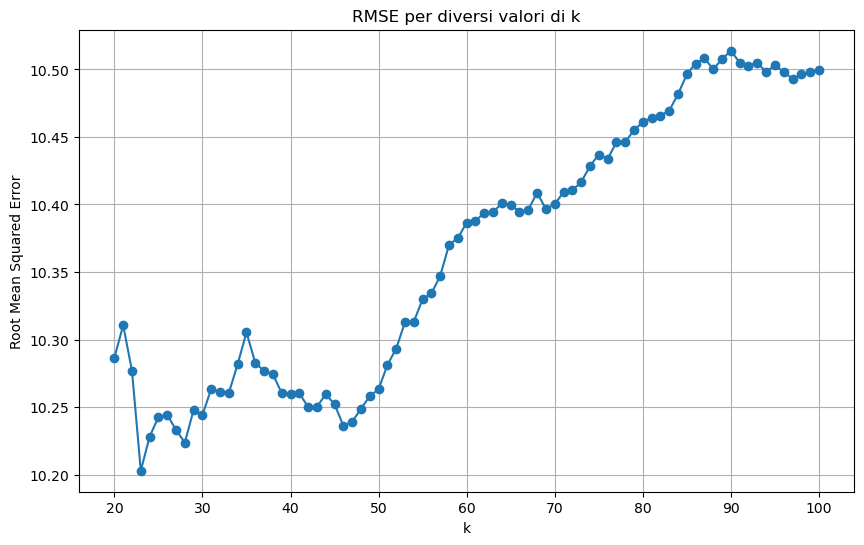

In [26]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

# Creare e addestrare il modello per diversi valori di k
scaler = StandardScaler()
X_s = scaler.fit_transform(X_train[list(best_subset)])
X_t_s = scaler.transform(X_test[list(best_subset)])

import matplotlib.pyplot as plt

k_values = range(20, 101)
rmse_values = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_s, y_train)
    
    # Effettuare previsioni sui dati di test
    y_pred = knn.predict(X_t_s)
    
    # Valutare le prestazioni del modello
    rmse = root_mean_squared_error(y_test, y_pred)  
    rmse_values.append(rmse)

# Creare il grafico
plt.figure(figsize=(10, 6))
plt.plot(k_values, rmse_values, marker='o')
plt.xlabel('k')
plt.ylabel('Root Mean Squared Error')
plt.title('RMSE per diversi valori di k')
plt.grid(True)
plt.show()

In [27]:
min_rmse = min(rmse_values)
best_k = k_values[rmse_values.index(min_rmse)]
print(f"Il valore minimo di RMSE è: {min_rmse} e il suo corrispettivo k è: {best_k}")

Il valore minimo di RMSE è: 10.20287947243426 e il suo corrispettivo k è: 23


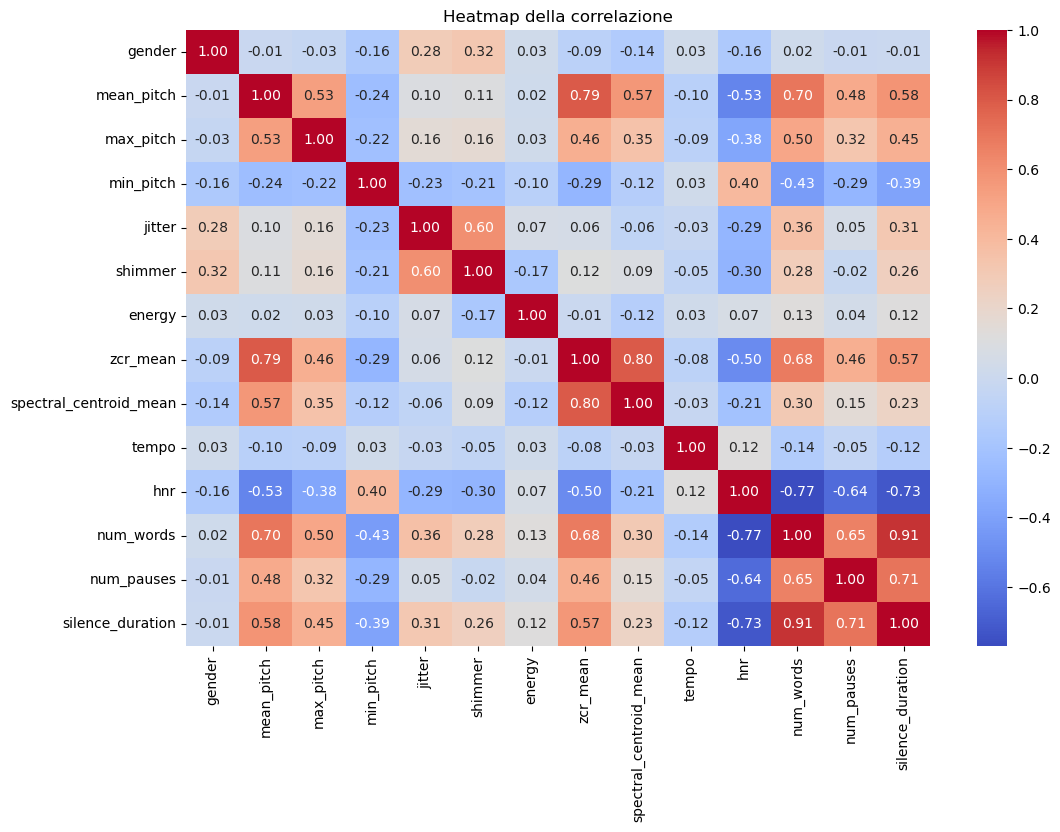

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcolare la matrice di correlazione
corr_matrix = X_train.corr()

# Creare la heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap della correlazione')
plt.show()

In [29]:
cols = list(best_subset)

df = pd.read_csv('data/development.csv').set_index('Id')
y = df['age']
X = df.drop('age', axis=1)
X = X[cols]
X['gender'] = X['gender'].map(gender)
X['tempo'] = X['tempo'].apply(lambda x: x.replace('[', '').replace(']', '')).astype('float')

scaler = StandardScaler()
knn = KNeighborsRegressor(n_neighbors=best_k)

X_s = scaler.fit_transform(X)   
knn.fit(X_s, y) 

KNeighborsRegressor(n_neighbors=23)

In [30]:

ef = pd.read_csv('data/evaluation.csv').set_index('Id') 
ef = ef[cols]
ef['gender'] = ef['gender'].map(gender)
ef['tempo'] = ef['tempo'].apply(lambda x: x.replace('[', '').replace(']', '')).astype('float')  

X_ef = scaler.transform(ef)
y_pred = knn.predict(X_ef)

output = pd.DataFrame({'Id': ef.index, 'Predicted': y_pred}).to_csv('out/knn.csv', index=False)


In [31]:
cols

['gender',
 'mean_pitch',
 'min_pitch',
 'jitter',
 'shimmer',
 'tempo',
 'hnr',
 'num_pauses',
 'silence_duration']